#Loading Data

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
DATA_DIR = '/content/drive/My Drive/FraudTransformer'

Mounted at /content/drive


In [ ]:
data_path = f'{DATA_DIR}/fe_banking_login_20201201_20210531.csv'

In [ ]:
feature_path = f'{DATA_DIR}/modified_coef_final4th.csv'

In [ ]:
raw_data = pd.read_csv(data_path)

In [ ]:
feature_list = pd.read_csv(feature_path)

In [ ]:
features = feature_list["Unnamed: 0"].astype("str").tolist()

In [ ]:
selected_data = raw_data[features+['frd', 'eval']]

In [ ]:
selected_data.rename({'tmxrc_Possible VPN or Tunnel': 'tmxrc_Possible_VPN_or_Tunnel'}, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
features[29] = 'tmxrc_Possible_VPN_or_Tunnel'

In [ ]:
selected_data.apply(pd.Series.value_counts)

tmxrc_Aggregator  tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS  \
0            915124                            738032   
1             19651                            196743   

   tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS  \
0                                          858212   
1                                           76563   

   tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH  \
0                                        828697   
1                                        106078   

   tmxrc_SMART_ID_LCL_AGE_GT_3MTHS  \
0                           409576   
1                           525199   

   tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS  \
0                                          852116   
1                                           82659   

   tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH  \
0                          925615   
1                            9160   

   tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS  \
0                                       665783   
1                                       268992   

   tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS  \
0                                         872812   
1                                          61963   

   tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH  ...  \
0                                     852589  ...   
1                                      82186  ...   

   tmxrc_ACC_EMAIL_GBL_AGE_LT_DY  tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_AGE_LT_DY  \
0                         931852                                     929281   
1                           2923                                       5494   

   tmxrc_Jailbreak_or_Root  tmxrc_Proxy_Anonymous  sumrc_Level_1_Link_Reject  \
0                   929089                 913852                     906871   
1                     5686                  20923                      27904   

   tmxrc_Rejected_ExactID_Month  tmxrc_PotentialVM_UA_Android_OS_Win  \
0                        906677                               931257   
1                         28098                                 3518   

   tmxrc_Phones_per_ExactID_Week_High     frd    eval  
0                              930973  801345  749142  
1                                3802  133430  185633  

[2 rows x 47 columns]

#Set Vocabulary

In [ ]:
vocab_file = "vocab.txt"
## do not rerun this code chunk

In [ ]:
vocab =['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]','[BOS]','[EOS]']
for feature in features:
  vocab.append(feature+"_0")
  vocab.append(feature+"_1")
## do not rerun this code chunk

In [ ]:
vocab

In [ ]:
with open(vocab_file, 'w') as vocab_fp:
  vocab_fp.write("\n".join(vocab))
## now the vocabulary is saved as vocab.txt

# Set Tokenizer

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 36.3 MB/s 
     |████████████████████████████████| 596 kB 56.9 MB/s 
     |████████████████████████████████| 101 kB 4.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer

In [ ]:
special_tokens_dict = {"unk_token": "[UNK]", 
                       "sep_token": "[SEP]", 
                       "pad_token": "[PAD]", 
                       "cls_token": "[CLS]", 
                       "mask_token": "[MASK]",
                       "eos_token": "[EOS]",
                       "bos_token": "[BOS]"}

In [ ]:
tokenizer = BertTokenizer(vocab_file,do_lower_case=False, do_basic_tokenize = False)

In [ ]:
tokenizer.add_special_tokens(special_tokens_dict)

0

In [ ]:
tokenized = tokenizer("tmxrc_Aggregator_0 tmxrc_Aggregator_1 tmxrc_Possible_VPN_or_Tunnel_0")

In [ ]:
tokenized

{'input_ids': [3, 7, 8, 65, 1], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

# Transform Data

In [ ]:
selected_data.shape

(934775, 47)

In [ ]:
train_data = selected_data[selected_data['eval'] == False].iloc[:,0:46]

In [ ]:
test_data = selected_data[selected_data['eval'] == True].iloc[:,0:46]

In [ ]:
train_data_features = train_data.iloc[:,0:45]

In [ ]:
train_data_labels = train_data.iloc[:,45]

In [ ]:
x = train_data_features.to_string(header=False,
                  index=False,
                  index_names=False).split('\n')
vals = [' '.join(ele.split()) for ele in x]

In [ ]:
for index in range(0,len(vals)):
  val = vals[index]
  val = list(val)
  for i in range(0,len(val),2):
    val[i] = features[i//2] + "_" + val[i]
  val = "".join(val)
  vals[index] = val

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 4.1 MB/s 
     |████████████████████████████████| 212 kB 25.3 MB/s 
     |████████████████████████████████| 115 kB 37.4 MB/s 
     |████████████████████████████████| 141 kB 39.1 MB/s 
     |████████████████████████████████| 127 kB 44.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from datasets import Dataset

In [ ]:
my_dict = {'text': vals, 'label': train_data_labels.to_list()}

In [ ]:
train_df = Dataset.from_dict(my_dict)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

In [ ]:
tokenized_train_df = train_df.map(tokenize_function, batched=True)

In [ ]:
#tokenized_train_df[0]

In [ ]:
train_data = selected_data[selected_data['eval'] == False].iloc[:,0:46]

In [ ]:
test_data = selected_data[selected_data['eval'] == True].iloc[:,0:46]

In [ ]:
train_data_features = train_data.iloc[:,0:45]

In [ ]:
train_data_labels = train_data.iloc[:,45]

In [ ]:
x = train_data_features.to_string(header=False,
                  index=False,
                  index_names=False).split('\n')
vals = [' '.join(ele.split()) for ele in x]

In [ ]:
for index in range(0,len(vals)):
  val = vals[index]
  val = list(val)
  for i in range(0,len(val),2):
    val[i] = features[i//2] + "_" + val[i]
  val = "".join(val)
  vals[index] = val

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 4.1 MB/s 
     |████████████████████████████████| 212 kB 25.3 MB/s 
     |████████████████████████████████| 115 kB 37.4 MB/s 
     |████████████████████████████████| 141 kB 39.1 MB/s 
     |████████████████████████████████| 127 kB 44.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from datasets import Dataset

In [ ]:
my_dict = {'text': vals, 'label': train_data_labels.to_list()}

In [ ]:
train_df = Dataset.from_dict(my_dict)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

In [ ]:
#tokenized_train_df = train_df.map(tokenize_function, batched=True)

In [ ]:
#tokenized_train_df[0]

In [ ]:
test_data_features = test_data.iloc[:,0:45]
test_data_labels = test_data.iloc[:,45]
x = test_data_features.to_string(header=False,
                  index=False,
                  index_names=False).split('\n')
vals = [' '.join(ele.split()) for ele in x]

for index in range(0,len(vals)):
  val = vals[index]
  val = list(val)
  for i in range(0,len(val),2):
    val[i] = features[i//2] + "_" + val[i]
  val = "".join(val)
  vals[index] = val

my_dict = {'text': vals, 'labels': test_data_labels.to_list()}
test_df = Dataset.from_dict(my_dict)
#tokenized_test_df = train_df.map(tokenize_function, batched=True)

In [ ]:
test_df[0]

{'label': 1,
 'text': 'tmxrc_Aggregator_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0 tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS_0 tmxrc_SMART_ID_LCL_AGE_GT_2WKS_0 tmxrc_DIG_ID_GBL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_LT_DY_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY_0 tmxrc_SMART_ID_GBL_AGE_LT_DY_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ExactID_Vel_per_Hour_High_0 tmxrc_ACC_LOGIN_LCL_AGE_LT_HR_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR_0 tmxrc_ExactID_Dist_per_Hour_High_0 tm

In [ ]:
# Note that the Fast Preprocessing TabularBERT notebook provides a much faster way to tokenize the training/testing dataset. 
# Please refer to that notebook for fast preprocessing. The APIs might be little different. Some essential steps are provided below

In [ ]:
vocab_dict = tokenizer.get_vocab()

In [ ]:
train_data_features = train_data.iloc[:,0:45]
train_data_labels = train_data.iloc[:,45]

In [ ]:
for column in train_data_features:
  train_data_features[column] = train_data_features[column].map(lambda x:column + "_" + str(x))
  train_data_features[column] = train_data_features[column].map(lambda x: vocab_dict.get(x, vocab_dict['[UNK]']))

In [ ]:
input_initial = train_data_features.to_numpy().tolist()

In [ ]:
input = [[3]+x+[1] for x in input_initial]

In [ ]:
my_dict = {'input_ids': input, 
           'labels': train_data_labels.to_list(), 
           'token_type_ids': [[0]*(len(train_data_features.columns)+2)]*len(train_data_features),
           'attention_mask': [[1]*(len(train_data_features.columns)+2)]*len(train_data_features)}

In [ ]:
train_df = Dataset.from_dict(my_dict)

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_df = train_df.with_format("torch", device=device)

# Get Model and Train

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!pip install accelerate nvidia-ml-py3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 4.0 MB/s 
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19190 sha256=e38c886b958b97af0ae23811db5b2edcc79e38e236f0904e4821e0a80625ec2e
  Stored in directory: /root/.cache/pip/wheels/df/99/da/c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
Successfully built nvidia-ml-py3


In [ ]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [ ]:
print_gpu_utilization()

GPU memory occupied: 2 MB.


In [ ]:
from transformers import BertConfig, BertForMaskedLM

In [ ]:
config = BertConfig(vocab_size=len(vocab),hidden_size=256,num_hidden_layers=4,num_attention_heads=4)

In [ ]:
model = BertForMaskedLM(config).to('cuda')

In [ ]:
from transformers import DataCollatorForLanguageModeling, Trainer, TrainingArguments, logging

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,mlm=True,mlm_probability=0.15)

In [ ]:
tokenized_train_df = tokenized_train_df.rename_columns({'label':'labels'})

In [ ]:
tokenized_train_df = tokenized_train_df.remove_columns(["text"]) 
tokenized_train_df.set_format("torch")

In [ ]:
tokenized_train_df[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'input_ids': tensor([ 3,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39,
         42, 44, 45, 48, 49, 51, 53, 55, 57, 59, 61, 64, 65, 67, 69, 71, 73, 75,
         77, 79, 81, 83, 85, 87, 89, 91, 93, 95,  1]),
 'labels': tensor(1),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [ ]:
torch.save(tokenized_train_df, '/content/drive/MyDrive/tensor.pt')

In [ ]:
logging.set_verbosity_error()

training_args = TrainingArguments(output_dir='/content/checkpoint', num_train_epochs=3)

trainer = Trainer(model=model, args=training_args, data_collator=data_collator, train_dataset=tokenized_train_df)
result = trainer.train()
print_summary(result)

# MLM Testing

In [ ]:
# Run loading data to set tokenizer
from transformers import BertForMaskedLM

In [ ]:
newmodel = BertForMaskedLM.from_pretrained('/content/drive/MyDrive/checkpoint-280500-pretrained')

In [ ]:
#newmodel.save_pretrained("/content")

Configuration saved in /content/config.json
Model weights saved in /content/pytorch_model.bin


In [ ]:
from transformers import pipeline
fill_mask = pipeline("fill-mask", model=newmodel, tokenizer=tokenizer)

In [ ]:
example = '[MASK] tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_1 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0 tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_1 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_1 tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_1 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS_1 tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS_0 tmxrc_SMART_ID_LCL_AGE_GT_2WKS_0 tmxrc_DIG_ID_GBL_AGE_GT_3MTHS_1 tmxrc_DIG_ID_LCL_AGE_GT_3MTHS_1 tmxrc_DIG_ID_LCL_AGE_LT_DY_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY_0 tmxrc_SMART_ID_GBL_AGE_LT_DY_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ExactID_Vel_per_Hour_High_0 tmxrc_ACC_LOGIN_LCL_AGE_LT_HR_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR_0 tmxrc_ExactID_Dist_per_Hour_High_0 tmxrc_Login_Dist_per_Day_High_0 tmxrc_TZ_Geo_Mismatch_0 tmxrc_Geo_Lang_Mismatch_0 tmxrc_Rejected_TrueIP_Month_0 tmxrc_Possible_VPN_or_Tunnel_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_LAST_TXN_1MIN_0 tmxrc_Email_Dist_per_Hour_High_0 tmxrc_Rejected_InputIP_Year_0 tmxrc_Rejected_InputIP_Month_0 tmxrc_Rejected_Email_Month_0 tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_LAST_TXN_15MIN_0 tmxrc_TMX_email_persona_anomaly_0 tmxrc_ACC_EMAIL_GBL_AGE_LT_DY_0 tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_Jailbreak_or_Root_0 tmxrc_Proxy_Anonymous_0 sumrc_Level_1_Link_Reject_0 tmxrc_Rejected_ExactID_Month_0 tmxrc_PotentialVM_UA_Android_OS_Win_0 tmxrc_Phones_per_ExactID_Week_High_0'

In [ ]:
fill_mask(example)

[{'score': 0.9999606609344482,
  'sequence': 'tmxrc_Aggregator_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_1 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0 tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_1 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_1 tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_1 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS_1 tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS_0 tmxrc_SMART_ID_LCL_AGE_GT_2WKS_0 tmxrc_DIG_ID_GBL_AGE_GT_3MTHS_1 tmxrc_DIG_ID_LCL_AGE_GT_3MTHS_1 tmxrc_DIG_ID_LCL_AGE_LT_DY_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY_0 tmxrc_SMART_ID_GBL_AGE_LT_DY_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ExactID_Vel_per_Hour_High_0 tmxrc_ACC_LOGIN_LCL_AGE_LT_HR_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR_0 tmxrc_ExactID_

# Visualization

In [ ]:
# Run loading data to set tokenizer
from transformers import BertModel

In [ ]:
import torch

In [ ]:
newmodel = BertModel.from_pretrained('/content/drive/MyDrive/checkpoint-280500-pretrained',output_attentions=True, output_hidden_states=True)

In [ ]:
newmodel.eval()

In [ ]:
input_str = 'tmxrc_Aggregator_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0 tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS_0 tmxrc_SMART_ID_LCL_AGE_GT_2WKS_0 tmxrc_DIG_ID_GBL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_LT_DY_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY_0 tmxrc_SMART_ID_GBL_AGE_LT_DY_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ExactID_Vel_per_Hour_High_0 tmxrc_ACC_LOGIN_LCL_AGE_LT_HR_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR_0 tmxrc_ExactID_Dist_per_Hour_High_0 tmxrc_Login_Dist_per_Day_High_0 tmxrc_TZ_Geo_Mismatch_0 tmxrc_Geo_Lang_Mismatch_0 tmxrc_Rejected_TrueIP_Month_0 tmxrc_Possible_VPN_or_Tunnel_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_LAST_TXN_1MIN_1 tmxrc_Email_Dist_per_Hour_High_0 tmxrc_Rejected_InputIP_Year_0 tmxrc_Rejected_InputIP_Month_0 tmxrc_Rejected_Email_Month_0 tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_LAST_TXN_15MIN_0 tmxrc_TMX_email_persona_anomaly_0 tmxrc_ACC_EMAIL_GBL_AGE_LT_DY_0 tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_Jailbreak_or_Root_0 tmxrc_Proxy_Anonymous_0 sumrc_Level_1_Link_Reject_0 tmxrc_Rejected_ExactID_Month_0 tmxrc_PotentialVM_UA_Android_OS_Win_0 tmxrc_Phones_per_ExactID_Week_High_0'
model_inputs = tokenizer(input_str, return_tensors="pt")

In [ ]:
model_inputs.input_ids[0].shape

torch.Size([47])

In [ ]:
with torch.no_grad():
    model_output = newmodel(**model_inputs)


print("Hidden state size (per layer):  ", model_output.hidden_states[0].shape)
print("Attention head size (per layer):", model_output.attentions[0].shape)     # (layer, batch, query_word_idx, key_word_idxs)
                                                                               # y-axis is query, x-axis is key
print(model_output) 

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(model_inputs.input_ids[0])
print(tokens)

['[CLS]', 'tmxrc_Aggregator_0', 'tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_0', 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0', 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0', 'tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_0', 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_0', 'tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0', 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0', 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0', 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_0', 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0', 'tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS_0', 'tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS_0', 'tmxrc_SMART_ID_LCL_AGE_GT_2WKS_0', 'tmxrc_DIG_ID_GBL_AGE_GT_3MTHS_0', 'tmxrc_DIG_ID_LCL_AGE_GT_3MTHS_0', 'tmxrc_DIG_ID_LCL_AGE_LT_DY_0', 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY_0', 'tmxrc_SMART_ID_GBL_AGE_LT_DY_0', 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY_0', 'tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY_0', 'tmxrc_ExactID_Vel_per_Hour_High_0', 'tmxrc_ACC_LOGIN_LCL_AGE_LT_HR_0', 'tmxrc_ACC_EMAIL_SMART_ID_L

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
n_layers = len(model_output.attentions)
n_heads = len(model_output.attentions[0][0])
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.set_size_inches(200,200)
for layer in range(n_layers):
    for i in range(n_heads):
        axes[layer][i].imshow(model_output.attentions[layer][0, i])
        axes[layer][i].set_xticks(list(range(48)))
        axes[layer][i].set_xticklabels(labels=tokens, rotation="vertical")
        axes[layer][i].set_yticks(list(range(48)))
        axes[layer][i].set_yticklabels(labels=tokens)
            

plt.show()

In [ ]:
!pip install bertviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 157 kB 4.3 MB/s 
     |████████████████████████████████| 1.3 MB 46.9 MB/s 
     |████████████████████████████████| 132 kB 62.7 MB/s 
     |████████████████████████████████| 9.0 MB 40.4 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 


In [ ]:
from bertviz import head_view, model_view
from bertviz.neuron_view import show
from transformers import BertTokenizer, BertModel

newmodel = BertModel.from_pretrained('/content/drive/MyDrive/checkpoint-280500-pretrained',output_attentions=True)
input_str = 'tmxrc_Aggregator_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0 tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS_0 tmxrc_SMART_ID_LCL_AGE_GT_2WKS_0 tmxrc_DIG_ID_GBL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_LT_DY_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY_0 tmxrc_SMART_ID_GBL_AGE_LT_DY_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ExactID_Vel_per_Hour_High_0 tmxrc_ACC_LOGIN_LCL_AGE_LT_HR_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR_0 tmxrc_ExactID_Dist_per_Hour_High_0 tmxrc_Login_Dist_per_Day_High_0 tmxrc_TZ_Geo_Mismatch_0 tmxrc_Geo_Lang_Mismatch_0 tmxrc_Rejected_TrueIP_Month_0 tmxrc_Possible_VPN_or_Tunnel_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_LAST_TXN_1MIN_1 tmxrc_Email_Dist_per_Hour_High_0 tmxrc_Rejected_InputIP_Year_0 tmxrc_Rejected_InputIP_Month_0 tmxrc_Rejected_Email_Month_0 tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_LAST_TXN_15MIN_0 tmxrc_TMX_email_persona_anomaly_0 tmxrc_ACC_EMAIL_GBL_AGE_LT_DY_0 tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_Jailbreak_or_Root_0 tmxrc_Proxy_Anonymous_0 sumrc_Level_1_Link_Reject_0 tmxrc_Rejected_ExactID_Month_0 tmxrc_PotentialVM_UA_Android_OS_Win_0 tmxrc_Phones_per_ExactID_Week_High_0'

Some weights of the model checkpoint at /content/drive/MyDrive/checkpoint-280500-pretrained were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /content/drive/MyDrive/checkpoint-280500-pretrained and are newly initial

In [ ]:
inputs = tokenizer.encode_plus(input_str, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = newmodel(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

In [ ]:
head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [ ]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>

# Finetune

In [ ]:
train_val = tokenized_train_df.train_test_split(test_size = 0.3)

In [ ]:
cls_train_df = train_val['train']
cls_val_df = train_val['test']

In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
clsmodel = BertForSequenceClassification.from_pretrained('/content/checkpoint/checkpoint-280500', num_labels=2).to('cuda')

loading configuration file /content/checkpoint/checkpoint-280500/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.21.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 97
}

loading weights file /content/checkpoint/checkpoint-280500/pytorch_model.bin
Some weights of the model checkpoint at /content/checkpoint/checkpoint-280500 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.pred

In [ ]:
arguments = TrainingArguments(
    output_dir="finetune",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    learning_rate=2e-5,
    load_best_model_at_end=True,
    seed=42
)


def compute_metrics(eval_pred):
    """Called at the end of validation. Gives accuracy"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # calculates the accuracy
    return {"accuracy": np.mean(predictions == labels)}


trainer = Trainer(
    model=clsmodel,
    args=arguments,
    train_dataset=cls_train_df,
    eval_dataset=cls_val_df, # change to test when you do your final evaluation!
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
import numpy as np

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 524399
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 98325


***** Running Evaluation *****
  Num examples = 224743
  Batch size = 16
Saving model checkpoint to finetune/checkpoint-32775
Configuration saved in finetune/checkpoint-32775/config.json
Model weights saved in finetune/checkpoint-32775/pytorch_model.bin
tokenizer config file saved in finetune/checkpoint-32775/tokenizer_config.json
Special tokens file saved in finetune/checkpoint-32775/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 224743
  Batch size = 16
Saving model checkpoint to finetune/checkpoint-65550
Configuration saved in finetune/checkpoint-65550/config.json
Model weights saved in finetune/checkpoint-65550/pytorch_model.bin
tokenizer config file saved in finetune/checkpoint-65550/tokenizer_config.json
Special tokens file saved in finetune/checkpoint-65550/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 224743
  Batch size = 16
Saving model checkpoint to finetune/checkpoint-98325
Configuration saved in finetune/checkpoint-98325/c

TrainOutput(global_step=98325, training_loss=0.24908812483363924, metrics={'train_runtime': 2954.6674, 'train_samples_per_second': 532.445, 'train_steps_per_second': 33.278, 'total_flos': 3295526512222116.0, 'train_loss': 0.24908812483363924, 'epoch': 3.0})

In [ ]:
finetunemodel = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/checkpoint-98325-finetuned', num_labels=2)

In [ ]:
finetunemodel.eval()

In [ ]:
from transformers import pipeline
cls_task = pipeline("sentiment-analysis", model=finetunemodel, tokenizer=tokenizer)

In [ ]:
#input = 'tmxrc_Aggregator_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0 tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS_0 tmxrc_SMART_ID_LCL_AGE_GT_2WKS_1 tmxrc_DIG_ID_GBL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_LT_DY_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY_0 tmxrc_SMART_ID_GBL_AGE_LT_DY_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ExactID_Vel_per_Hour_High_0 tmxrc_ACC_LOGIN_LCL_AGE_LT_HR_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR_1 tmxrc_ExactID_Dist_per_Hour_High_0 tmxrc_Login_Dist_per_Day_High_0 tmxrc_TZ_Geo_Mismatch_0 tmxrc_Geo_Lang_Mismatch_0 tmxrc_Rejected_TrueIP_Month_1 tmxrc_Possible_VPN_or_Tunnel_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_LAST_TXN_1MIN_0 tmxrc_Email_Dist_per_Hour_High_0 tmxrc_Rejected_InputIP_Year_0 tmxrc_Rejected_InputIP_Month_0 tmxrc_Rejected_Email_Month_0 tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_LAST_TXN_15MIN_0 tmxrc_TMX_email_persona_anomaly_1 tmxrc_ACC_EMAIL_GBL_AGE_LT_DY_0 tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_Jailbreak_or_Root_0 tmxrc_Proxy_Anonymous_0 sumrc_Level_1_Link_Reject_0 tmxrc_Rejected_ExactID_Month_0 tmxrc_PotentialVM_UA_Android_OS_Win_0 tmxrc_Phones_per_ExactID_Week_High_0'

In [ ]:
input = test_df['text']

In [ ]:
cls_task(input)

In [ ]:
items = cls_task(input)

Disabling tokenizer parallelism, we're using DataLoader multithreading already


In [ ]:
pred_score = [item['score'] if item['label']=='LABEL_1' else (1-item['score']) for item in items]

In [ ]:
refs = test_df['label']

In [ ]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.2 MB/s 


In [ ]:
import evaluate
roc_auc_score = evaluate.load("roc_auc")

In [ ]:
results = roc_auc_score.compute(references=refs, prediction_scores=pred_score)

In [ ]:
results

{'roc_auc': 0.8844057193945226}

# SHAP

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.0 MB/s 


In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
finetunemodel = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/checkpoint-98325-finetuned', num_labels=2)

In [ ]:
import transformers
import datasets
import shap
import numpy as np

In [ ]:
classifier = transformers.pipeline("sentiment-analysis", model=finetunemodel, tokenizer=tokenizer, return_all_scores=True)
classifier(test_df['text'][0:5])

`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality


[[{'label': 'LABEL_0', 'score': 0.5710344314575195},
  {'label': 'LABEL_1', 'score': 0.4289655089378357}],
 [{'label': 'LABEL_0', 'score': 0.6064373254776001},
  {'label': 'LABEL_1', 'score': 0.3935626745223999}],
 [{'label': 'LABEL_0', 'score': 0.22306668758392334},
  {'label': 'LABEL_1', 'score': 0.7769333124160767}],
 [{'label': 'LABEL_0', 'score': 0.7493295669555664},
  {'label': 'LABEL_1', 'score': 0.2506704330444336}],
 [{'label': 'LABEL_0', 'score': 0.8332705497741699},
  {'label': 'LABEL_1', 'score': 0.1667294204235077}]]

In [ ]:
test_df['label'][0:5]

[1, 1, 1, 1, 1]

In [ ]:
# define the explainer
explainer = shap.Explainer(classifier)

In [ ]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(test_df['text'][5:6])

  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 2/5 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 4/5 [00:17<00:02,  2.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 5/5 [00:23<00:00,  4.11s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 6it [00:28,  7.17s/it]


In [ ]:
shap.plots.text(shap_values[:,:,"LABEL_1"])

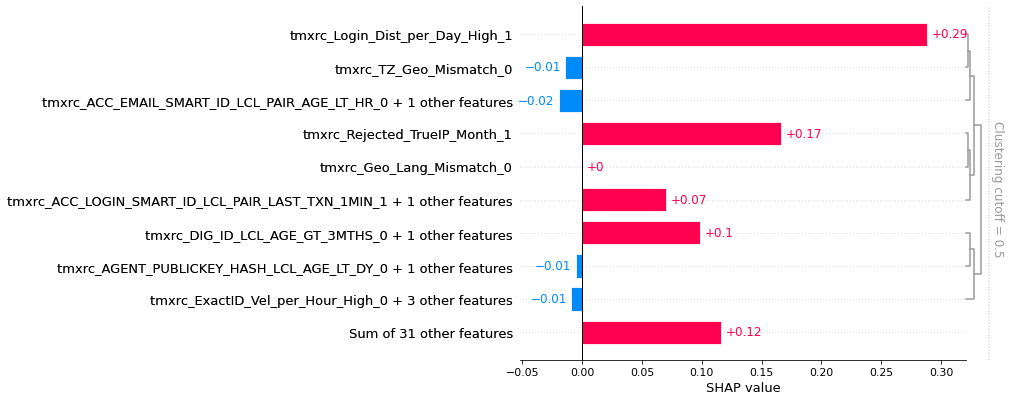

In [ ]:
shap.plots.bar(shap_values[7,:,"LABEL_1"])

# Shuffle Test

In [ ]:
test_data.columns.tolist()

In [ ]:
shuffle_cols = ['tmxrc_Phones_per_ExactID_Week_High',
 'tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS',
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS',
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH',
 'tmxrc_SMART_ID_LCL_AGE_GT_3MTHS',
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS',
 'tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH',
 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS',
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS',
 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH',
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS',
 'tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS',
 'tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS',
 'tmxrc_SMART_ID_LCL_AGE_GT_2WKS',
 'tmxrc_DIG_ID_GBL_AGE_GT_3MTHS',
 'tmxrc_DIG_ID_LCL_AGE_GT_3MTHS',
 'tmxrc_DIG_ID_LCL_AGE_LT_DY',
 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY',
 'tmxrc_SMART_ID_GBL_AGE_LT_DY',
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY',
 'tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY',
 'tmxrc_ExactID_Vel_per_Hour_High',
 'tmxrc_ACC_LOGIN_LCL_AGE_LT_HR',
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR',
 'tmxrc_ExactID_Dist_per_Hour_High',
 'tmxrc_Login_Dist_per_Day_High',
 'tmxrc_TZ_Geo_Mismatch',
 'tmxrc_Geo_Lang_Mismatch',
 'tmxrc_Rejected_TrueIP_Month',
 'tmxrc_Possible_VPN_or_Tunnel',
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_LAST_TXN_1MIN',
 'tmxrc_Email_Dist_per_Hour_High',
 'tmxrc_Rejected_InputIP_Year',
 'tmxrc_Rejected_InputIP_Month',
 'tmxrc_Rejected_Email_Month',
 'tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_LAST_TXN_15MIN',
 'tmxrc_TMX_email_persona_anomaly',
 'tmxrc_ACC_EMAIL_GBL_AGE_LT_DY',
 'tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_AGE_LT_DY',
 'tmxrc_Jailbreak_or_Root',
 'tmxrc_Proxy_Anonymous',
 'sumrc_Level_1_Link_Reject',
 'tmxrc_Rejected_ExactID_Month',
 'tmxrc_PotentialVM_UA_Android_OS_Win',
 'tmxrc_Aggregator',
 'frd']

In [ ]:
shuffle_data = test_data[shuffle_cols]

In [ ]:
shuffle_features = shuffle_cols[:-1]

In [ ]:
!pip install datasets

In [ ]:
from datasets import Dataset

In [ ]:
shuffle_data_features = shuffle_data.iloc[:,0:45]
shuffle_data_labels = shuffle_data.iloc[:,45]
x = shuffle_data_features.to_string(header=False,
                  index=False,
                  index_names=False).split('\n')
vals = [' '.join(ele.split()) for ele in x]

for index in range(0,len(vals)):
  val = vals[index]
  val = list(val)
  for i in range(0,len(val),2):
    val[i] = shuffle_features[i//2] + "_" + val[i]
  val = "".join(val)
  vals[index] = val

my_dict = {'text': vals, 'label': shuffle_data_labels.to_list()}
shuffle_df = Dataset.from_dict(my_dict)

In [ ]:
shuffle_data.iloc[0]

tmxrc_Phones_per_ExactID_Week_High                 0
tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS                   0
tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS     0
tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH       0
tmxrc_SMART_ID_LCL_AGE_GT_3MTHS                    0
tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS     0
tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH                     0
tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS        0
tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS      0
tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH          0
tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS     0
tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS                    0
tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS     0
tmxrc_SMART_ID_LCL_AGE_GT_2WKS                     0
tmxrc_DIG_ID_GBL_AGE_GT_3MTHS                      0
tmxrc_DIG_ID_LCL_AGE_GT_3MTHS                      0
tmxrc_DIG_ID_LCL_AGE_LT_DY                         0
tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY           0
tmxrc_SMART_ID_GBL_AGE_LT_DY                  

In [ ]:
shuffle_df[0]

{'label': 1,
 'text': 'tmxrc_Phones_per_ExactID_Week_High_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0 tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS_0 tmxrc_SMART_ID_LCL_AGE_GT_2WKS_0 tmxrc_DIG_ID_GBL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_LT_DY_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY_0 tmxrc_SMART_ID_GBL_AGE_LT_DY_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ExactID_Vel_per_Hour_High_0 tmxrc_ACC_LOGIN_LCL_AGE_LT_HR_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR_0 tmxrc_ExactID_Dist_

In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
finetunemodel = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/checkpoint-98325-finetuned', num_labels=2)

In [ ]:
finetunemodel.eval()

In [ ]:
from transformers import pipeline
cls_task = pipeline("sentiment-analysis", model=finetunemodel, tokenizer=tokenizer)

In [ ]:
input = shuffle_df['text']

In [ ]:
items = cls_task(input)

In [ ]:
pred_score = [item['score'] if item['label']=='LABEL_1' else (1-item['score']) for item in items]

In [ ]:
refs = shuffle_df['label']

In [ ]:
!pip install evaluate

In [ ]:
import evaluate
roc_auc_score = evaluate.load("roc_auc")

In [ ]:
results = roc_auc_score.compute(references=refs, prediction_scores=pred_score)

In [ ]:
results

{'roc_auc': 0.8788475521670692}

# Missing Test

In [ ]:
test_data.columns.tolist()

['tmxrc_Aggregator',
 'tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS',
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS',
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH',
 'tmxrc_SMART_ID_LCL_AGE_GT_3MTHS',
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS',
 'tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH',
 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS',
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS',
 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH',
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS',
 'tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS',
 'tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS',
 'tmxrc_SMART_ID_LCL_AGE_GT_2WKS',
 'tmxrc_DIG_ID_GBL_AGE_GT_3MTHS',
 'tmxrc_DIG_ID_LCL_AGE_GT_3MTHS',
 'tmxrc_DIG_ID_LCL_AGE_LT_DY',
 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY',
 'tmxrc_SMART_ID_GBL_AGE_LT_DY',
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY',
 'tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY',
 'tmxrc_ExactID_Vel_per_Hour_High',
 'tmxrc_ACC_LOGIN_LCL_AGE_LT_HR',
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR',
 'tmxrc_Exac

In [ ]:
missing_cols = ['tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS',
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS',
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH',
 'tmxrc_SMART_ID_LCL_AGE_GT_3MTHS',
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS',
 'tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH',
 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS',
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS',
 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH',
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS',
 'tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS',
 'tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS',
 'tmxrc_SMART_ID_LCL_AGE_GT_2WKS',
 'tmxrc_DIG_ID_GBL_AGE_GT_3MTHS',
 'tmxrc_DIG_ID_LCL_AGE_GT_3MTHS',
 'tmxrc_DIG_ID_LCL_AGE_LT_DY',
 'tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY',
 'tmxrc_SMART_ID_GBL_AGE_LT_DY',
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY',
 'tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY',
 'tmxrc_ExactID_Vel_per_Hour_High',
 'tmxrc_ACC_LOGIN_LCL_AGE_LT_HR',
 'tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR',
 'tmxrc_ExactID_Dist_per_Hour_High',
 'tmxrc_Login_Dist_per_Day_High',
 'tmxrc_TZ_Geo_Mismatch',
 'tmxrc_Geo_Lang_Mismatch',
 'tmxrc_Rejected_TrueIP_Month',
 'tmxrc_Possible_VPN_or_Tunnel',
 'tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_LAST_TXN_1MIN',
 'tmxrc_Email_Dist_per_Hour_High',
 'tmxrc_Rejected_InputIP_Year',
 'tmxrc_Rejected_InputIP_Month',
 'tmxrc_Rejected_Email_Month',
 'tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_LAST_TXN_15MIN',
 'tmxrc_TMX_email_persona_anomaly',
 'tmxrc_ACC_EMAIL_GBL_AGE_LT_DY',
 'tmxrc_ACC_NUM_SMART_ID_LCL_PAIR_AGE_LT_DY',
 'tmxrc_Jailbreak_or_Root',
 'tmxrc_Proxy_Anonymous',
 'sumrc_Level_1_Link_Reject',
 'tmxrc_Rejected_ExactID_Month',
 'tmxrc_PotentialVM_UA_Android_OS_Win',
 'tmxrc_Phones_per_ExactID_Week_High',
 'frd']

In [ ]:
missing_data = test_data[missing_cols]

In [ ]:
missing_features = missing_cols[:-1]

In [ ]:
!pip install datasets

In [ ]:
from datasets import Dataset

In [ ]:
missing_data_features = missing_data.iloc[:,0:44]
missing_data_labels = missing_data.iloc[:,44]
x = missing_data_features.to_string(header=False,
                  index=False,
                  index_names=False).split('\n')
vals = [' '.join(ele.split()) for ele in x]

for index in range(0,len(vals)):
  val = vals[index]
  val = list(val)
  for i in range(0,len(val),2):
    val[i] = missing_features[i//2] + "_" + val[i]
  val = "".join(val)
  vals[index] = val

my_dict = {'text': vals, 'label': missing_data_labels.to_list()}
missing_df = Dataset.from_dict(my_dict)

In [ ]:
missing_data.iloc[0]

tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS                   0
tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS     0
tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH       0
tmxrc_SMART_ID_LCL_AGE_GT_3MTHS                    0
tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS     0
tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH                     0
tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS        0
tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS      0
tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH          0
tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS     0
tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS                    0
tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS     0
tmxrc_SMART_ID_LCL_AGE_GT_2WKS                     0
tmxrc_DIG_ID_GBL_AGE_GT_3MTHS                      0
tmxrc_DIG_ID_LCL_AGE_GT_3MTHS                      0
tmxrc_DIG_ID_LCL_AGE_LT_DY                         0
tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY           0
tmxrc_SMART_ID_GBL_AGE_LT_DY                       0
tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY   

In [ ]:
missing_df[0]

{'label': 1,
 'text': 'tmxrc_ACC_EMAIL_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_MTH_0 tmxrc_SMART_ID_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_LCL_AGE_GT_MTH_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_LOGIN_SMART_ID_LCL_PAIR_AGE_GT_2WKS_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_GT_MTH_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_GT_2MTHS_0 tmxrc_ACC_NAME_LCL_AGE_GT_3MTHS_0 tmxrc_ACC_EMAIL_SMART_ID_GBL_PAIR_AGE_GT_2MTHS_0 tmxrc_SMART_ID_LCL_AGE_GT_2WKS_0 tmxrc_DIG_ID_GBL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_GT_3MTHS_0 tmxrc_DIG_ID_LCL_AGE_LT_DY_0 tmxrc_AGENT_PUBLICKEY_HASH_LCL_AGE_LT_DY_0 tmxrc_SMART_ID_GBL_AGE_LT_DY_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ACC_LOGIN_EXACT_ID_LCL_PAIR_AGE_LT_DY_0 tmxrc_ExactID_Vel_per_Hour_High_0 tmxrc_ACC_LOGIN_LCL_AGE_LT_HR_0 tmxrc_ACC_EMAIL_SMART_ID_LCL_PAIR_AGE_LT_HR_0 tmxrc_ExactID_Dist_per_Hour_High_0 tmxrc_Login_Dist_per_

In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
finetunemodel = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/checkpoint-98325-finetuned', num_labels=2)

In [ ]:
finetunemodel.eval()

In [ ]:
from transformers import pipeline
cls_task = pipeline("sentiment-analysis", model=finetunemodel, tokenizer=tokenizer)

In [ ]:
input = missing_df['text']

In [ ]:
items = cls_task(input)

In [ ]:
pred_score = [item['score'] if item['label']=='LABEL_1' else (1-item['score']) for item in items]

In [ ]:
refs = missing_df['label']

In [ ]:
!pip install evaluate

In [ ]:
import evaluate
roc_auc_score = evaluate.load("roc_auc")

In [ ]:
results = roc_auc_score.compute(references=refs, prediction_scores=pred_score)

In [ ]:
results

{'roc_auc': 0.8583552112293882}

# Logistic Comparison

In [ ]:
train_X = train_data.iloc[:,0:45]

In [ ]:
train_Y = train_data.iloc[:,45]

In [ ]:
test_X = test_data.iloc[:,0:45]

In [ ]:
test_Y = test_data.iloc[:,45]

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression(max_iter = 3000).fit(train_X, train_Y)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(test_Y, logreg.predict_proba(test_X)[:, 1])

0.8752049030424767

# XGBoost

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 3.1 s (started: 2022-08-30 21:39:36 +00:00)


In [ ]:
from xgboost import XGBClassifier

time: 75.6 ms (started: 2022-08-30 21:40:04 +00:00)


In [ ]:
model = XGBClassifier()
model.fit(train_data_features, train_data_labels)

XGBClassifier()

time: 1min 10s (started: 2022-08-30 21:41:27 +00:00)


In [ ]:
X_test = test_data.iloc[:,0:45]
y_test = test_data.iloc[:,45]

time: 1.15 ms (started: 2022-08-30 21:43:45 +00:00)


In [ ]:
y_pred = model.predict_proba(X_test)

time: 329 ms (started: 2022-08-30 21:46:32 +00:00)


In [ ]:
y_scores = y_pred[:, 1]

time: 510 µs (started: 2022-08-30 21:47:31 +00:00)


In [ ]:
y_scores

array([0.32238477, 0.2407574 , 0.6565904 , ..., 0.15303338, 0.15303338,
       0.15303338], dtype=float32)

time: 3.98 ms (started: 2022-08-30 21:47:38 +00:00)


In [ ]:
y_true = np.array(y_test)

time: 1.1 ms (started: 2022-08-30 21:48:15 +00:00)


In [ ]:
y_true

array([1, 1, 1, ..., 0, 0, 0])

time: 3.14 ms (started: 2022-08-30 21:48:20 +00:00)


In [ ]:
from sklearn.metrics import roc_auc_score

time: 765 µs (started: 2022-08-30 21:50:29 +00:00)


In [ ]:
roc_auc_score(y_true, y_scores)

0.8068778444893652

time: 44.1 ms (started: 2022-08-30 21:50:51 +00:00)


# LightGBM

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 81.8 MB/s 
time: 10.9 s (started: 2022-08-30 21:56:03 +00:00)


In [ ]:
from catboost import CatBoostClassifier

time: 22.5 ms (started: 2022-08-30 21:56:17 +00:00)


In [ ]:
clf = CatBoostClassifier()

time: 791 µs (started: 2022-08-30 21:57:10 +00:00)


In [ ]:
clf.fit(train_data_features, train_data_labels)

In [ ]:
X_test = test_data.iloc[:,0:45]
y_test = test_data.iloc[:,45]

time: 1.2 ms (started: 2022-08-30 22:03:27 +00:00)


In [ ]:
y_pred = clf.predict_proba(X_test)

time: 129 ms (started: 2022-08-30 22:03:35 +00:00)


In [ ]:
y_scores = y_pred[:, 1]

time: 798 µs (started: 2022-08-30 22:03:49 +00:00)


In [ ]:
y_true = np.array(y_test)

time: 1.21 ms (started: 2022-08-30 22:03:51 +00:00)


In [ ]:
from sklearn.metrics import roc_auc_score

time: 666 µs (started: 2022-08-30 22:03:53 +00:00)


In [ ]:
roc_auc_score(y_true, y_scores)

0.8030712122120683

time: 43.2 ms (started: 2022-08-30 22:03:55 +00:00)
